In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Opening JSON file
f = open('6hoNS9LR1Lxb4EzMX72kXR.json')
   
# returns JSON object as 
# a dictionary
data = json.load(f)

# a list to store only the transcripts and start times
new_list = []
failed_list = []
# Iterating through the json
# list
#for i in range(1,3):
for i in range(1, len(data['results'])):
    try:
        script = data['results'][i]['alternatives'][0]['transcript']
        start = data['results'][i]['alternatives'][0]['words'][0]['startTime']
    
        new_list.append((script, start))
        
    except:
        failed_list.append(data['results'][i]['alternatives'][0])
    
f.close()

In [22]:
[y[1] for y in new_list].index('2405.800s')

81

In [23]:
[y[1] for y in new_list].index('2672.800s')

94

In [24]:
dog_list = new_list[81:95]

In [6]:
# speakers: 
# 1: man
# 3: woman

# script length: 2405.8 - 2667.1
# 261.3s
# 4min 21.3sec
total_len = 261.3

In [3]:
missed_df = pd.read_csv('dog_missed_script.csv')

In [4]:
missed_df

,timestamp,duration,script,speakerTag
0,41:10-41:13,3,It is. It is not,1
1,41:33-41:35,2,"Ah. Yes, they are.",3
2,42:11-42:13,2,I understand.,1
3,42:21-42:22,1,Definitely not,1
4,43:38-43:39,1,It's okay.,1
5,43:45-43:47,2,It's not right because,1
6,43:50-43:51,1,No.,3
7,44:10-44:12,2,Wow. That's uncalled for.,1


In [7]:
missed_duration = np.sum(missed_df['duration'])
missed_ratio = missed_duration / total_len

In [8]:
print('In the dog script, {:1.3}% of the conversations did not get transcribed.'.format(missed_ratio*100))

In the dog script, 5.36% of the conversations did not get transcribed.


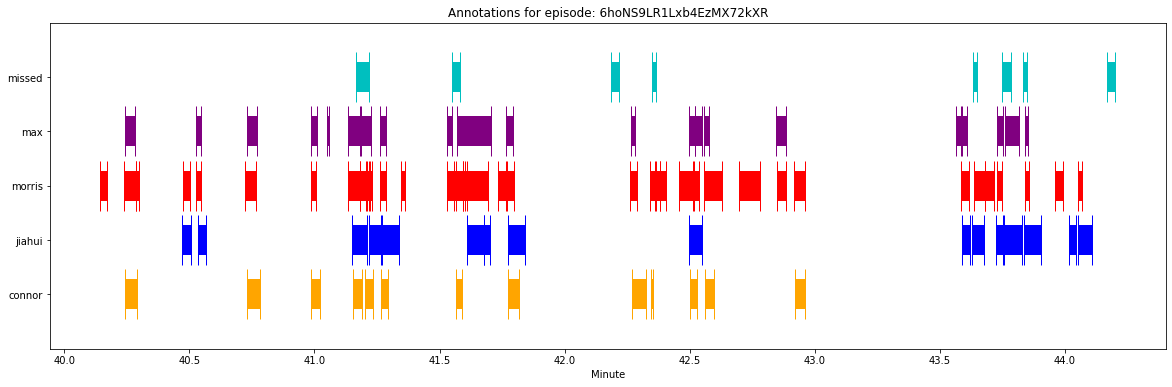

In [19]:
annotator_colors = {
    'connor': 'orange',
    'jiahui': 'blue',
    'morris': 'red',
    'max': 'purple'
}
def plot_missed_script(compiled_annotations_df, missed_df, annotator_colors):
    """Plot timeline, filtering df to episode_id; plot params are annotator_colors, y_step"""
    df = compiled_annotations_df
    plt.figure(figsize=(20,6))
    for i, annotator in enumerate(annotator_colors):
        i_df = df[df['annotator'] == annotator]
        for (start,end) in i_df[['start', 'end']].values:
            plt.plot([start/60, end/60], [i, i], 
                     marker = '|', 
                     color = annotator_colors[annotator], 
                     linewidth = 30, markersize = 50, solid_capstyle="butt")
            
    for timestamp in missed_df['timestamp']:
        startTime = float(timestamp[:2]) +  float(timestamp[3:5])/60 
        endtTime = float(timestamp[6:8]) +  float(timestamp[9:])/60 
        plt.plot([startTime, endtTime], [4, 4], 
                     marker = '|', 
                     color = 'c', 
                     linewidth = 30, markersize = 50, solid_capstyle="butt")
    
    annotator_colors['missed'] = 'c'  
    plt.xlabel("Minute")
    plt.title(f"Annotations for episode: 6hoNS9LR1Lxb4EzMX72kXR")
    plt.ylim(-1, len(annotator_colors))
    plt.yticks(range(len(annotator_colors)), annotator_colors)
    
plot_missed_script(annotations_df, missed_df, annotator_colors)

Transcript quality: good for most long sentences. Can miss a bit at start. Most misses are when two people are talking at the same time, and when the man has a fainted low-pitch voice.

## Text Disagreement Detection Toy Model

In [48]:
signal_list = ['disagree', 'No', "I don't think so", "That's not true"]
disagree_count  = 0
disagree_list = []
for i in range(len(dog_list)):
    script = dog_list[i][0]
    for signal in signal_list:
        if signal in script:
            disagree_count += 1
            disagree_list.append(dog_list[i])

In [49]:
disagree_count

5

In [50]:
# most are "No"s, one "disagree"
disagree_list

[(" If anything that is like not slightly Gary, you know that I'm right they keep a dog in this little tiny ass apartment. They never take it for walks because they're alone and can't find a boyfriend. It's not the dog's fault. You're a fucking loser. That is not first of all, are you are you saying? That's what I am. No, you're just laughing because he knows it's true. No, it's just the most ridiculous tape.",
  '2443.400s'),
 (" I met you I like that you think you saved my life. No, I don't think I saved your life. I think I added to it. I think you added to mine, but you I definitely had a dog. Yeah because I wanted company and it was really difficult because I knew I was going to be on the road, but I had wanted a dog for a really long time and I had a cat so I was like, oh perfect they can play together and they did until my cat died and my dog and I had a great time and I had a house sitter that would stay at my",
  '2501.200s'),
 (" You are an exception. Most people get animals 

In [9]:
file_names = ['max_annotations.jsonl', 'connor_annotations.jsonl', 'morris_annotations.jsonl', 'jiahui_annotations.jsonl']
names = ['max', 'connor', 'morris','jiahui']
def compile_annotations(file_names):
    annotator_list = []
    start_list = []
    end_list = []
    for i in range(len(names)):
        f = open(file_names[i])
        annotation = json.load(f)
        f.close()
        
        audio_spans = annotation['audio_spans']
        for span in audio_spans:
            annotator_list.append(names[i])
            start_list.append(span['start'])
            end_list.append(span['end'])
            
    annotations_df = pd.DataFrame({'annotator': annotator_list, 'start': start_list, 'end': end_list})
    
    return annotations_df

In [10]:
annotations_df = compile_annotations(file_names)

In [77]:
model_annotations = [{'startTime': 2462.800, 'endTime': 2463.400, 'word': 'No,'},
                     {'startTime': 2468.200, 'endTime': 2468.500, 'word': 'No,'},
                    {'startTime': 2506.100, 'endTime': 2506.300, 'word': 'No,'},
                     {'startTime': 2550.200, 'endTime': 2550.700, 'word': 'disagree'},
                     {'startTime': 2553.500, 'endTime': 2553.900, 'word': 'No,'},
                     {'startTime': 2593.600, 'endTime': 2594.100, 'word': 'No,'}
                    ]

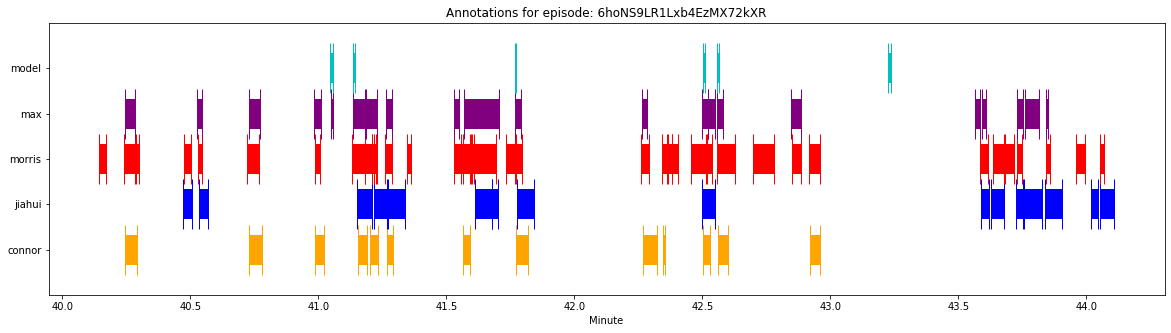

In [80]:
annotator_colors = {
    'connor': 'orange',
    'jiahui': 'blue',
    'morris': 'red',
    'max': 'purple'
}
def plot_annotations(compiled_annotations_df, annotator_colors):
    """Plot timeline, filtering df to episode_id; plot params are annotator_colors, y_step"""
    df = compiled_annotations_df
    plt.figure(figsize=(20,5))
    for i, annotator in enumerate(annotator_colors):
        i_df = df[df['annotator'] == annotator]
        for (start,end) in i_df[['start', 'end']].values:
            plt.plot([start/60, end/60], [i, i], 
                     marker = '|', 
                     color = annotator_colors[annotator], 
                     linewidth = 30, markersize = 50, solid_capstyle="butt")
            
    for segment_dict in model_annotations:
        startTime = segment_dict['startTime']
        endtTime = segment_dict['endTime']
        plt.plot([startTime/60, endtTime/60], [4, 4], 
                     marker = '|', 
                     color = 'c', 
                     linewidth = 30, markersize = 50, solid_capstyle="butt")
    
    annotator_colors['model'] = 'c'  
    plt.xlabel("Minute")
    plt.title(f"Annotations for episode: 6hoNS9LR1Lxb4EzMX72kXR")
    plt.ylim(-1, len(annotator_colors))
    plt.yticks(range(len(annotator_colors)), annotator_colors)
    
plot_annotations(annotations_df, annotator_colors)

In [11]:
missed_df

,timestamp,duration,script,speakerTag
0,41:10-41:13,3,It is. It is not,1
1,41:33-41:35,2,"Ah. Yes, they are.",3
2,42:11-42:13,2,I understand.,1
3,42:21-42:22,1,Definitely not,1
4,43:38-43:39,1,It's okay.,1
5,43:45-43:47,2,It's not right because,1
6,43:50-43:51,1,No.,3
7,44:10-44:12,2,Wow. That's uncalled for.,1
